<a href="https://colab.research.google.com/github/kerryback/WRDS/blob/main/Black_Jensen_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview

We're going to form portfolios based on rolling-window beta estimates.  Then, we ask whether the returns of these portfolios are consistent with the CAPM.  We present both of the tests proposed by Black, Jensen, and Scholes.

In [1]:
!pip install --upgrade statsmodels

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as pdr
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Read the file created and saved in the CRSP_Compustat notebook.

In [13]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/crsp_compustat_example.csv', parse_dates=['date'])
df.date = df.date.dt.to_period('M')
df = df.sort_values(by=['permno','date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Merge the market excess return and risk-free rate

Use the pandas data reader to read the Fama-French factors from Ken French's data library.  The data reader returns a dictionary.  The key 0 corresponds to the value-weighted monthly returns.  The returns are in percentage format (10%=10).  Divide by 100 to convert them to decimals (10%=0.10).  Then merge the market excess return and risk-free rate into the CRSP/Compustat data, broadcasting them across permnos.

In [15]:
ff = pdr('F-F_Research_Data_Factors','famafrench',start='1962-01-01')[0] / 100
df = df.merge(ff[['Mkt-RF','RF']],left_on='date',right_index=True,how='left')

# Betas from rolling-window regressions

In [16]:
# rolling 60-month regressions
# use try/except to avoid interruption with error message when a stock is in the dataset for fewer than 60 months

def rollingBeta(d) :
    try :
        result = RollingOLS(d.ret-d.RF,sm.add_constant(d['Mkt-RF']),window=60,min_nobs=24).fit()
        result = pd.DataFrame(result.params['Mkt-RF'])
        result.index = d.date
        result.columns = ['beta']
        return result
    except :
        return pd.DataFrame(np.nan,index=d.date,columns=['beta'])
betas = df.groupby('permno').apply(rollingBeta)
df = df.merge(betas,left_on=['permno','date'],right_index=True,how='left')

# Sort and compute value weighted returns

Sort into deciles each month by the lagged beta estimate and compute portfolio returns (value weighted within deciles).

In [19]:
# lag beta so it is the beta from the prior 60 months 
# me is already lagged from CRSP_Compustat notebook
df.beta = df.groupby('permno').beta.shift()
df2 = df.dropna(subset=['me','beta','ret'],how='any')

# sort into beta deciles each month
df2['decile'] = df2.groupby('date').beta.apply(lambda x: pd.qcut(x,10,labels=range(1,11)))

# compute value-weighted returns
rets = df2.groupby(['date','decile']).apply(lambda d: (d.me*d.ret).sum() / d.me.sum())
rets = rets.unstack('decile')
df2 = df2.drop(columns=['decile'])

# merge market excess return and risk-free rate
rets = rets.merge(ff[['Mkt-RF','RF']],left_index=True,right_index=True,how='inner')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# BJS Test I

Test whether $\alpha=0$ in a time-series regression for each beta portfolio:
$$R-RF = \alpha + \beta (Mkt-RF) + \varepsilon$$
This is a separate test for each portfolio.  We'll pull the alphas, t-stats, and p-values into a dataframe.  We'll also add the betas.  

We can see that the low-beta (ex ante) portfolios do have lower betas (ex post).  The low beta portfolios also have positive alphas, contradicting the CAPM.

In [20]:
table = pd.DataFrame(dtype=float,index=range(1,11),columns=['rprem','beta','alpha','tstat','pval'])
X = sm.add_constant(rets['Mkt-RF'])
for i in range(1,11) :
    y = rets[i]-rets.RF
    result = sm.OLS(y,X).fit()
    table.loc[i,'rprem'] = y.mean()
    table.loc[i,'beta'] = result.params['Mkt-RF']
    table.loc[i,'alpha'] = result.params['const']
    table.loc[i,'tstat'] = result.tvalues['const']
    table.loc[i,'pval'] = result.pvalues['const']
table.round(3)    

,rprem,beta,alpha,tstat,pval
1,0.005,0.541,0.002,1.750,0.081
2,0.006,0.652,0.002,2.203,0.028
3,0.006,0.783,0.002,2.053,0.040
4,0.007,0.854,0.002,2.650,0.008
5,0.006,0.963,0.001,1.057,0.291
6,0.007,1.049,0.001,1.014,0.311
7,0.006,1.173,-0.001,-0.910,0.363
8,0.007,1.274,-0.001,-1.260,0.208
9,0.006,1.433,-0.003,-2.531,0.012
10,0.007,1.696,-0.004,-2.311,0.021


# BJS Test II

This is a test of whether average excess returns depend on full-sample ex-post betas as predicted by the Security Market Line.  The Security Market Line is
$$E[R-RF] = \beta E[Mkt-RF]$$
so if we regress average excess returns on betas, we should get an intercept of 0 and a slope coefficient equal to the mean market excess return.  Empirically, the intercept is too large and the slope is too small.  The following shows that the intercept is too large, and we cannot reject that the slope is zero.

In [21]:
X = sm.add_constant(table.beta)
y = table.rprem
sm.OLS(y,X).fit().summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rprem   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.059
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.334
Time:                        16:52:32   Log-Likelihood:                 61.149
No. Observations:                  10   AIC:                            -118.3
Df Residuals:                       8   BIC:                            -117.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.001      9.283      0.000       0.004       0.007
beta           0.0006      0.001      1.029      0.334      -0.001       0.002
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.237
Skew:                          -0.070   Prob(JB):                        0.888
Kurtosis:                       2.258   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can visualize the fact that the empirical SML is too flat and has an intercept that is too large by comparing it to the theoretical SML as follows.  The slope of the theoretical SML is the market risk premium.

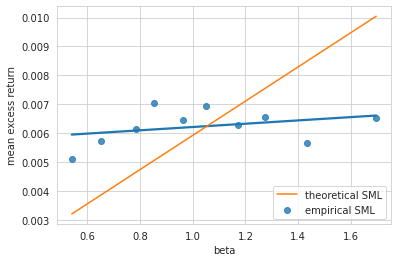

In [22]:
sns.regplot(data=table,x='beta',y='rprem',ci=None,label='empirical SML')
mkt_riskprem = rets['Mkt-RF'].mean()
plt.plot(table.beta,mkt_riskprem*table.beta,label='theoretical SML')
plt.xlabel('beta')
plt.ylabel('mean excess return')
plt.legend(loc='lower right')

# Save data frame with betas

In [23]:
df2.to_csv('/content/drive/My Drive/crsp_compustat_example2.csv',index=False)